In [1]:
import networkx as nx
import ast
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import multiprocessing as mp
#from sage.graphs.graph_decompositions.graph_products import is_cartesian_product
import CodeModules.GFKTools as gfk
import time
import pickle

TIMERS = True

In [2]:
def comp_from_pickle(filename = 'DefaultPickleComp', grade = True):

    graph, size, knot = imp_from_pickle(filename)
    print("Grid complex imported with grid number = " + str(size))
    nxg, defield = construct_cinf(graph, size)
    if grade:
        print('proceeding to grade complex.')
        nxg = grade_complex(nxg, defield)
    
    return nxg, defield

def imp_from_pickle(filename = 'DefaultPickleComp'):
    
    if filename == 'DefaultPickleComp':
        print('No name provided for import - importing from DefaultPickleComp')
    
    
    try:
        file = open(filename,'rb')
        print("file opened")
    except:
        print('Ran into an error: Make sure you\'ve exported to the file you\'re trying to import from')
    stuff = pickle.load(file)
    file.close()
    print('file closed')
    return stuff
    
    


def name_some_vars(letters, num):
    result = []
    num = int(num)
    for letter in letters:
        
        for i in range(num):
            new_var = f"{letter}{i}"
            #print(new_var)
            result.append(new_var)
    
    return result

def construct_cinf(g, size = -1): #Construct CFKinf complex from graph data - essentially just changing weights to polynomials
                                  #Only works for grid diagrams *not* Latin Squares
    print('constructing cinf...')
    if size == -1:
        size = len(g.get_edge_data(list(g.edges())[0][0],list(g.edges())[0][1])['diffweight'])  #kind of a mess - just turning the edges
        print("Grid size is " + str(size/2))
        n = size/2                                                                              #into a list and checking the length of#the weight of the first edge
    else:
        n = size
    timerstart = time.time()
    F,Vars = cinf_coeff(n)
    resG = nx.DiGraph()
    for edge in g.edges:
        
        start = edge[0]
        end = edge[1]
        poly = F(1)
        i = 0
        for entry in g[edge[0]][edge[1]]['diffweight']:
            
            poly = poly*(Vars[i])**entry
            i = i + 1
            
        resG.add_edge(start,end,diffweight = poly)
    
    timerend = time.time()
    elap = timerend - timerstart
    print('Time to construct cinf '+ str(elap))
    return resG, F
        
def cinf_coeff(size):
    
    n = size
    varis = name_some_vars(['U','V'],n)
    F = LaurentPolynomialRing(GF(2), varis)
    F.inject_variables()
  
    return F,list(F.gens())


def range_skip_entry(n, skip):
    u = []
    for i in range(0, skip): u.append(i)
    for j in range(skip+1, n): u.append(j)       
    return u

        
    
def mod_out_uv(chain_comp, field):
    gens = field.gens()
    size = len(gens)/2    
    for edge in chain_comp.edges():
    
        for i in range(size):
            
            src = edge[0]
            tar = edge[1]
#             print(gens[0])
#             print(gens[size])
#             print(chain_comp[src][tar]['diffweight'])
            chain_comp[src][tar]['diffweight'] = chain_comp[src][tar]['diffweight'].subs({gens[i]:gens[0]})
            chain_comp[src][tar]['diffweight'] = chain_comp[src][tar]['diffweight'].subs({gens[size+i]:gens[size]})
        print(chain_comp[src][tar]['diffweight'])

            
    return 1

def to_hat(chain_comp, field):

    print("setting Ui's and Vi's = 0")
    gens = field.gens()
    size = len(gens)/2    
    for edge in chain_comp.edges():
    
        for i in range(2*size):
            
            src = edge[0]
            tar = edge[1]
            chain_comp[src][tar]['diffweight'] = chain_comp[src][tar]['diffweight'].subs({gens[i]:0})

    return 1

def to_minus(chain_comp, field):
#Substitutes U0 for all the Ui
    
    print("normalizing Ui's and to i = 0 and Vi = 1")
    gens = field.gens()
    size = len(gens)/2    
    for edge in chain_comp.edges():
    
        for i in range(size):
            
            src = edge[0]
            tar = edge[1]
            chain_comp[src][tar]['diffweight'] = chain_comp[src][tar]['diffweight'].subs({gens[i]:gens[0]})
            chain_comp[src][tar]['diffweight'] = chain_comp[src][tar]['diffweight'].subs({gens[i+size]:1})
            
    remove_zeros(chain_comp)
    return 1

def normalize(chain_comp, field):
#Substitutes U0 for all the Ui
    
    gens = field.gens()
    size = len(gens)/2    
    for edge in chain_comp.edges():
    
        for i in range(size):
            
            src = edge[0]
            tar = edge[1]
            chain_comp[src][tar]['diffweight'] = chain_comp[src][tar]['diffweight'].subs({gens[i]:gens[0]})
            chain_comp[src][tar]['diffweight'] = chain_comp[src][tar]['diffweight'].subs({gens[i+size]:gens[size]})
            
    remove_zeros(chain_comp)
    return 1

def remove_zeros(chain_comp):
    
    elist = list(chain_comp.edges())
    for x,y in elist:
    
        if chain_comp[x][y]['diffweight'] == 0:
            
            chain_comp.remove_edge(x,y)
            
    return 1

def gml_export_weighted(graph, filename = 'PleaseNameMe.gml'):

    nxG = graph.copy()
    
    if filename == 'PleaseNameMe.gml':
        print("You didn't name your output! It's been named PleaseNameMe.gml")
    
    if filename[-4:] != ".gml":
        filename += ".gml"
    
    for x,y in nxG.edges():
        
        nxG[x][y]['diffweight'] = str(nxG[x][y]['diffweight'])
        
    for node in nxG.nodes():
        
        #print(str((nxG.nodes()[node]['UGrading'],nxG.nodes()[node]['VGrading'],nxG.nodes()[node]['AGrading'])))

        nxG.nodes[node]['AGrading'] = int(nxG.nodes[node]['AGrading']) 
        nxG.nodes[node]['UGrading'] = int(nxG.nodes[node]['UGrading'])
        nxG.nodes[node]['VGrading'] = int(nxG.nodes[node]['VGrading'])
        
    nx.write_gml(nxG, filename)
        
    return



In [3]:
def graph_red_search(given_graph, started = False, timerstart = None): 
#searches through a cfk inf complex for reducible edges and calling
#the reduction function to eliminate the pair according to the reduction algorithm
#     dict_graph = nx.to_dict_of_dicts(given_graph)
    if not started:
        timerstart = time.time()    
        print("Reducing complex...")
    
    for key in given_graph:
        
        for target in given_graph[key]:
            
            if given_graph[key][target]['diffweight'] == 1:
                given_graph = graph_reduction(given_graph, key, target)
                return graph_red_search(given_graph, True, timerstart)
            
    timerstop = time.time()
    print('Time to reduce complex: ' + str(timerstop - timerstart))
            
    return given_graph

def graph_reduction(given_graph, key, target):
#Deletes edge specified from graph_red_search and adds in edges according to the
#reduction algorithm
    for x in given_graph.predecessors(target):
        
        if x == key: continue
        for y in given_graph.successors(key):
        
            if y == target: continue
            x_weight = given_graph[x][target]['diffweight']
            y_weight = given_graph[key][y]['diffweight']
            red_weight = x_weight * y_weight
            if given_graph.has_edge(x,y):
                old_weight = given_graph[x][y]['diffweight']
                red_weight = red_weight + old_weight
            given_graph.add_edge(x,y,diffweight=red_weight)

    given_graph.remove_node(key)
    given_graph.remove_node(target)
    return given_graph

def remove_loops(givengraph, overwrite = True):
    
    if overwrite:
        graph = givengraph
    else:
        graph = givengraph.copy()
    
    for ed in list(graph.edges()):
        try:
            out = graph.edges()(ed[0],ed[1])
            back = graph.edges()[ed[1],ed[0]]
            graph.remove_edge(ed[0],ed[1])
            graph.remove_edge(ed[1],ed[0])
        except KeyError:
            continue
            
    return graph

def remove_NU_loops(givengraph, overwrite = True):
    
    if overwrite:
        graph = givengraph
    else:
        graph = givengraph.copy()
    
    for ed in list(graph.edges()):
        try:
            out = graph.edges()(ed[0],ed[1])
            back = graph.edges()[ed[1],ed[0]]
            if graph[ed[0]][ed[1]]['diffweight'] == 1:
                continue
            if graph[ed[1]][ed[0]]['diffweight'] == 1:
                continue
            graph.remove_edge(ed[0],ed[1])
            graph.remove_edge(ed[1],ed[0])
        except KeyError:
            continue
            
    return graph

In [4]:
def grade_complex(given_graph, given_field, gridX = -1):
    
    #Input: given_graph a networkx directed graph with 'diffweight' attribute on edges
    #       given_field the laurent polynomial field associated to the grid graph
    #       gridX a list representing the vertex to be graded 0 in U V and Alexander gradings
    #
    #Output: given_graph with new attributes on the vertices for U V and Alexander gradings
    #        also an attribute HasBeenGraded as an artifact
    
    
    #If the positions of the Xs aren't provided we'll initialize around whatever
    #state happens to appear first in the digraph structure
    if gridX == -1:
        
        gridX = list(given_graph.nodes())[0]
    
    gens = given_field.gens()
    size = len(gens)/2 

    print("grading complex...")
    
    #Adding an attribute to all nodes to keep track of if they've been assigned gradings
    nx.set_node_attributes(given_graph, False, "HasBeenGraded")
    
    #The gradings are relative so we're declaring one to be in U, V, and Alexander grading 0
    #this block initializes those balues
    given_graph.nodes()[str(gridX)]['HasBeenGraded'] = True
    given_graph.nodes()[str(gridX)]['AGrading'] = 0
    given_graph.nodes()[str(gridX)]['UGrading'] = 0
    given_graph.nodes()[str(gridX)]['VGrading'] = 0
    
    if TIMERS: timerstart = time.time()

    #Built in function to find a spanning tree
    span = nx.algorithms.tree.branchings.greedy_branching(given_graph)
    
    if TIMERS:
        
        timerstop = time.time()
        print("Time to find arborescence:" + str(timerstop - timerstart))
    
    #Bit of baseball terminology for the following nested loops, the active data is essentially at bat, the list we're working
    #through is called on_deck, and then we're building up the follow up as in_the_hole which will turn into
    #on deck on the following loop
    #
    #On deck holds the edges to be iterated through
    on_deck = [str(gridX)]
    
    #In the hole holds the ones to be iterated through once on_deck is cleared
    in_the_hole = []
    
    if TIMERS: timerstart = time.time()
    
    while len(on_deck) > 0: 
               
        for vert in on_deck:

            #Every vertex in on_deck should be graded. The loops iterate through the neighbors of each of these
            #vertices, grading them and then adding them to in_the_hole, ignoring vertices that have already been graded.
            #
            #The loop is broken into two halves since we have two flavors of neighbor in a directed graph, successors and
            #predecessors, named accordingly. These flavors differ in relative grading change by a sign.
            for succ in span.successors(vert): 
                
                #skip the vertex if its already been graded
                if given_graph.nodes()[succ]['HasBeenGraded']: continue
                    
                in_the_hole.append(succ)
                
                ed_weight = given_graph[vert][succ]['diffweight']
                
                #set the maslov (homological) gradings
                Upows = U_deg(ed_weight, given_field)
                given_graph.nodes()[succ]['UGrading'] = given_graph.nodes()[vert]['UGrading'] - 1 + 2*Upows

                Vpows = V_deg(ed_weight, given_field)
                given_graph.nodes()[succ]['VGrading'] = given_graph.nodes()[vert]['VGrading'] - 1 + 2*Vpows

                #Alexander grading is a function of the U and V grading, set here
                given_graph.nodes()[succ]['AGrading'] = (1/2)*(given_graph.nodes()[succ]['UGrading']-given_graph.nodes()[succ]['VGrading'])

                given_graph.nodes()[succ]['HasBeenGraded'] = True

            for pred in span.predecessors(vert):
                
                if given_graph.nodes()[pred]['HasBeenGraded']: continue
                in_the_hole.append(pred)
                ed_weight = given_graph[pred][vert]['diffweight']
                
                #set the maslov (homological) gradings, note the negative grading change since we're following an arrow backwards.
                Upows = U_deg(ed_weight, given_field)
                given_graph.nodes()[pred]['UGrading'] = given_graph.nodes()[vert]['UGrading'] + 1 - 2*Upows       

                Vpows = V_deg(ed_weight, given_field)
                given_graph.nodes()[pred]['VGrading'] = given_graph.nodes()[vert]['VGrading'] + 1 - 2*Vpows

                given_graph.nodes()[pred]['AGrading'] = (1/2)*(given_graph.nodes()[pred]['UGrading']-given_graph.nodes()[pred]['VGrading'])
                given_graph.nodes()[pred]['HasBeenGraded'] = True
                
        on_deck = in_the_hole
        in_the_hole =[]
        
    if TIMERS:
        
        timerstop = time.time()
        print('Time to grade complex (given arborescence): ' + str(timerstop - timerstart))
    
    return given_graph
            

    
def U_deg(poly, field):
    
    #Input: poly a laurent polynomial (must be  a monomial) in field a laurent polynomial ring
    #
    #Output: The total sum of powers of Ui in poly
    
    gens = field.gens()
    size = len(gens)/2
    degree = 0
    
    if type(poly) == sage.rings.finite_rings.integer_mod.IntegerMod_int: return 0
    
    powers = poly.exponents()   
    
    #len(powers) tells you how many terms the polynomial has
    if len(powers) > 1:
        
        raise Exception("Ran into a non-homogoneous degree change - polynomial wasn't a monomial")

    if len(powers) == 0:
        
        return 0    
    
    #powers is a list of lists since its intended for more than just monomials, since we are guaranteeing
    #a monomial at this point we'll just lift that inner list out
    powers = powers[0]
    
    for i in range(size):
        
        degree = degree + powers[i]
    
    return degree

    
def V_deg(poly, field):
    
    #Input: poly a laurent polynomial (must be  a monomial) in field a laurent polynomial ring
    #
    #Output: The total sum of powers of Ui in poly    
    
    gens = field.gens()
    size = len(gens)/2
    degree = 0
    
    if type(poly) == sage.rings.finite_rings.integer_mod.IntegerMod_int: return 0
    
    powers = poly.exponents()   
    
    #len(powers) tells you how many terms the polynomial has    
    if len(powers) > 1:
        
        raise Exception("Ran into a non-homogoneous degree change - polynomial wasn't a monomial")

    if len(powers) == 0:
        
        return 0    
    
    #powers is a list of lists since its intended for more than just monomials, since we are guaranteeing
    #a monomial at this point we'll just lift that inner list out    
    powers = powers[0]
    for i in range(size):
        
        degree = degree + powers[size + i]
    
    return degree    
    


In [5]:
#converting braid notation to a grid --- this is not a unique choice in general so we're going to make some decisions

class braid:
    
    def __init__(self, recipe, size = 0):
        if size == 0:
            candidate1 = max(recipe)
            candidate2 = abs(min(recipe))
            size = max([candidate1,candidate2])+1
        self.strands = []
        for i in range(1, size+1):
            self.strands.append(i)
        self.recipe = recipe
        self.size = size    
        
def braid_to_cromwell(given):
    n = given.size
    closing_heights = []
    for i in range(n):
        closing_heights.append(i+1)
    cromwell = [] #We're going to keep track of corners of the knot as a cromwell matrix (0's and 1's) and track the ones here by marking the two heights
                  #for example [[3,1],[2,3],[1,2]] contains the information for a 3x3. The Cromwell matrix won't see the sub-ordering
    strands = given.strands.copy()
    for sig in given.recipe:
        new_entry = crom_twist(sig, strands, cromwell, closing_heights)
        cromwell.append(new_entry)
    for i in range(len(strands)):
        if strands[i] != closing_heights[i]:
            cromwell.append([closing_heights[i],strands[i]])
    return cromwell

def crom_twist(bmove, strings, current_crom, closing_ht):
    coord = []
    n = len(strings)
    if bmove > 0:
        lower = strings[bmove-1]
        upper = strings[bmove]
        for i in range(len(current_crom)):     #move previous cromwell stuff up to make room as below
            crom_twist_helper_pos(current_crom[i], lower, upper)
        for i in range(bmove+1, n):            #move the strands up to make room for rectilinear braid move
            strings[i] += 1
        for i in range(len(closing_ht)):
            if closing_ht[i] > upper:
                closing_ht[i] += 1
        cm1 = [strings[bmove-1],strings[bmove]+1] #\/\/\/this is where the braid move actually "happens" \/\/\/
        strings[bmove-1] = strings[bmove]
        strings[bmove] = strings[bmove] + 1
    elif bmove < 0:
        bmove = (-1)*bmove
        lower = strings[bmove-1]
        upper = strings[bmove]
        for i in range(len(current_crom)):     #move previous cromwell stuff up to make room as below
            crom_twist_helper_neg(current_crom[i], lower, upper)
        for i in range(bmove-1, n):            #move the strands up to make room for rectilinear braid move
            strings[i] += 1
        for i in range(len(closing_ht)):
            if closing_ht[i] >= lower:
                closing_ht[i] += 1
        cm1 = [strings[bmove],strings[bmove-1]-1] #\/\/\/this is where the braid move actually "happens" \/\/\/
        strings[bmove] = strings[bmove - 1]
        strings[bmove-1] = strings[bmove - 1] - 1
    else:
        print("invalid braid move")
    return cm1

def crom_twist_helper_neg(crom_pair, lower, upper):
    for i in range(2):
        if crom_pair[i] >= lower:
            crom_pair[i] += 1
    return

def crom_twist_helper_pos(crom_pair, lower, upper):
    for i in range(2):
        if crom_pair[i] > upper:
            crom_pair[i] += 1
    return

def cromwell_to_grid(cromwell_pairs):
    n = len(cromwell_pairs)
    xhold = []
    ohold = []
    for i in range(n):
        xhold.append(0)
        ohold.append(0)
#     print(cromwell_pairs)
    xhold[0] = cromwell_pairs[0][0]
    ohold[0] = cromwell_pairs[0][1]
    count = 2
    cromwell_pairs[0] = [-1,-1]
    while count < 2*n:
        for i in range(n):
            for j in range(2):
                if ((cromwell_pairs[i][j] in xhold)and (not(cromwell_pairs[i][j] in ohold))):
                    ohold[i] = cromwell_pairs[i][j]
                    xhold[i] = cromwell_pairs[i][j-1]
                    cromwell_pairs[i] = [-1,-1]
                    count += 2
                elif ((cromwell_pairs[i][j] in ohold)and (not(cromwell_pairs[i][j] in xhold))):
                    xhold[i] = cromwell_pairs[i][j]
                    ohold[i] = cromwell_pairs[i][j-1]
                    cromwell_pairs[i] = [-1,-1]
                    count += 2
    return (xhold,ohold)

def grid_from_braid(bnotation):
    
    br = braid(bnotation)
    crom = braid_to_cromwell(br)
    xlist, olist = cromwell_to_grid(crom)
    return xlist, olist

In [51]:
raw_tref = gfk.build_cinf([[5, 1, 2, 3, 4], [2, 3, 4, 5, 1]])
tref, defield = construct_cinf(raw_tref)

constructing cinf...
Grid size is 10 and has type <class 'int'>
Defining U0, U1, U2, U3, U4, V0, V1, V2, V3, V4
Time to construct cinf 0.0344235897064209


In [9]:
raw_tref = gfk.build_cinf([[6, 1, 4, 5, 3, 2], [3, 5, 6, 2, 1, 4]])
tref, defield = construct_cinf(raw_tref)
# to_minus(tref, defield)
normalize(tref, defield)
grade_complex(tref, defield)
graph_red_search(tref)

remove_zeros(tref)
gml_export_weighted(tref, "4_1Normalized")

constructing cinf...
Grid size is 6
Defining U0, U1, U2, U3, U4, U5, V0, V1, V2, V3, V4, V5
Time to construct cinf 0.45931315422058105
grading complex...
Time to find arborescence:0.01652836799621582
Time to grade complex (given arborescence): 0.020597219467163086
Reducing complex...
Time to reduce complex: 2.7372734546661377


In [7]:
curcomp, defield = comp_from_pickle()
graph_red_search(curcomp)
gml_export_weighted(curcomp, '4_1Reduced')

No name provided for import - importing from DefaultPickleComp
file opened
file closed
Grid complex imported with grid number = 6
constructing cinf...
Defining U0, U1, U2, U3, U4, U5, V0, V1, V2, V3, V4, V5
Time to construct cinf 0.4841477870941162
proceeding to grade complex.
grading complex...
Time to find arborescence:0.03833365440368652
Time to grade complex (given arborescence): 0.030751943588256836
Reducing complex...
Time to reduce complex: 7.02778434753418


In [8]:
curcomp, defield = comp_from_pickle('trefcomppickle')
graph_red_search(curcomp)
gml_export_weighted(curcomp, 'trefReduced')

file opened
file closed
Grid complex imported with grid number = 5
constructing cinf...
Defining U0, U1, U2, U3, U4, V0, V1, V2, V3, V4
Time to construct cinf 0.03891277313232422
proceeding to grade complex.
grading complex...
Time to find arborescence:0.0498814582824707
Time to grade complex (given arborescence): 0.004714250564575195
Reducing complex...
Time to reduce complex: 0.19043755531311035


In [ ]:
g = gfk.build_cinf([[1,2,3,4,5],[2,3,4,5,1]])

In [11]:
nxG, defield = imp_and_construct_complex('testCinfExport.gml')

U0
U1
U2
U3
U4
V0
V1
V2
V3
V4
Defining U0, U1, U2, U3, U4, V0, V1, V2, V3, V4


In [ ]:
nx.algorithms.tree.branchings.greedy_branching

In [ ]:
nxG.nodes()['[2, 5, 3, 1, 4]']

In [11]:
nxG, defield = imp_and_construct_complex('Figure8.gml')
# nx.set_node_attributes(nxG, None, "AGrading")
# nx.set_node_attributes(nxG, None, "MGrading")
grade_complex(nxG, defield)


# remove_NU_loops(nxG, True)
# graph_red_search(nxG)
# to_minus(nxG, defield)
# remove_zeros(nxG)
# normalize(nxG, defield)
# to_hat(nxG, defield)
# remove_zeros(nxG)
# span = nx.minimum_spanning_arborescence(nxG)
graph_red_search(nxG)
# remove_loops(nxG, defield)
# nx.write_gml(span, "redspan.gml")
gml_export_weighted(nxG, "Figure8DelLoops")

U0
U1
U2
U3
U4
U5
V0
V1
V2
V3
V4
V5
Defining U0, U1, U2, U3, U4, U5, V0, V1, V2, V3, V4, V5
(-1, -1, 0)
(1, -1, 1)
(0, -2, 1)
(0, 0, 0)
(0, 0, 0)
(-1, -1, 0)
(-1, -1, 0)
(1, -1, 1)
(1, -1, 1)
(-1, 1, -1)
(-1, -1, 0)
(-2, 0, -1)
(-2, 0, -1)
(0, -2, 1)
(0, -2, 1)
(2, 0, 1)
(-2, 0, -1)
(-3, -1, -1)
(-3, -1, -1)
(-3, -1, -1)
(-1, -1, 0)
(1, -3, 2)
(1, -1, 1)
(1, -1, 1)
(-2, -2, 0)
(0, -2, 1)
(-2, -2, 0)
(0, -2, 1)
(0, -4, 2)
(0, -2, 1)
(0, -2, 1)
(0, -2, 1)
(-1, -1, 0)
(-1, -1, 0)
(-1, -3, 1)
(-1, -1, 0)
(-1, -1, 0)
(-1, -3, 1)
(1, -1, 1)
(-1, -3, 1)
(-1, -3, 1)
(-1, -3, 1)
(-1, -1, 0)
(-1, -1, 0)
(-2, 0, -1)
(0, 0, 0)
(-2, 0, -1)
(-2, -2, 0)
(-2, -4, 1)
(-2, -2, 0)
(-2, -2, 0)
(0, -2, 1)
(0, -2, 1)
(0, -2, 1)
(-2, -2, 0)
(-2, 0, -1)
(0, -2, 1)
(0, -2, 1)
(0, -2, 1)
(-2, -2, 0)
(0, -2, 1)
(-2, -2, 0)
(-2, -2, 0)
(-1, -1, 0)
(-1, -1, 0)
(-1, -1, 0)
(-3, -1, -1)
(-3, 1, -2)
(-1, -1, 0)
(-3, -1, -1)
(-1, -3, 1)
(-1, -3, 1)
(-3, -3, 0)
(-3, -1, -1)
(-3, -1, -1)
(-1, -1, 0)
(-1, -1, 0)
(-1, -3,

In [85]:
nxG['[1, 2, 3, 5, 4]']

AtlasView({'[2, 1, 3, 5, 4]': {'diffweight': 1}, '[1, 3, 2, 5, 4]': {'diffweight': 1}, '[1, 2, 5, 3, 4]': {'diffweight': V2}, '[4, 2, 3, 5, 1]': {'diffweight': U4}, '[1, 2, 3, 4, 5]': {'diffweight': U4*V2}, '[1, 2, 4, 5, 3]': {'diffweight': U3}, '[5, 2, 3, 1, 4]': {'diffweight': V3}})

In [86]:
graph_red_search(nxG)

In [87]:
gml_export_weighted(nxG)

In [62]:
"mystring"[-4:]

'ring'

In [6]:
g = convert_gml('testCinfExport.gml')
sageG = construct_sageG_cinf(g)
dictg = nx.to_dict_of_dicts(g)
# newg = DiGraph()
#graphs.graph_input.from_dict_of_dicts(dictg, weighted = True)
# newg
myf = sageG.weighted_adjacency_matrix()

U0
U1
U2
U3
U4
V0
V1
V2
V3
V4
Defining U0, U1, U2, U3, U4, V0, V1, V2, V3, V4


In [30]:
f = U0*U1*V2

In [31]:
f.subs(U0=V2)

U1*V2^2

In [7]:
nxG, defield = construct_cinf(g)

U0
U1
U2
U3
U4
V0
V1
V2
V3
V4
Defining U0, U1, U2, U3, U4, V0, V1, V2, V3, V4


In [8]:
nxG.edges()

OutEdgeView([('[1, 2, 3, 5, 4]', '[2, 1, 3, 5, 4]'), ('[1, 2, 3, 5, 4]', '[1, 3, 2, 5, 4]'), ('[1, 2, 3, 5, 4]', '[1, 2, 5, 3, 4]'), ('[1, 2, 3, 5, 4]', '[4, 2, 3, 5, 1]'), ('[1, 2, 3, 5, 4]', '[1, 2, 3, 4, 5]'), ('[1, 2, 3, 5, 4]', '[1, 2, 4, 5, 3]'), ('[1, 2, 3, 5, 4]', '[5, 2, 3, 1, 4]'), ('[2, 1, 3, 5, 4]', '[2, 3, 1, 5, 4]'), ('[2, 1, 3, 5, 4]', '[2, 1, 5, 3, 4]'), ('[2, 1, 3, 5, 4]', '[4, 1, 3, 5, 2]'), ('[2, 1, 3, 5, 4]', '[1, 2, 3, 5, 4]'), ('[2, 1, 3, 5, 4]', '[2, 1, 3, 4, 5]'), ('[2, 1, 3, 5, 4]', '[3, 1, 2, 5, 4]'), ('[2, 1, 3, 5, 4]', '[2, 1, 4, 5, 3]'), ('[2, 1, 3, 5, 4]', '[5, 1, 3, 2, 4]'), ('[2, 1, 3, 5, 4]', '[2, 4, 3, 5, 1]'), ('[2, 1, 3, 5, 4]', '[2, 5, 3, 1, 4]'), ('[1, 3, 2, 5, 4]', '[3, 1, 2, 5, 4]'), ('[1, 3, 2, 5, 4]', '[4, 3, 2, 5, 1]'), ('[1, 3, 2, 5, 4]', '[1, 3, 5, 2, 4]'), ('[1, 3, 2, 5, 4]', '[1, 2, 3, 5, 4]'), ('[1, 3, 2, 5, 4]', '[1, 3, 2, 4, 5]'), ('[1, 3, 2, 5, 4]', '[2, 3, 1, 5, 4]'), ('[1, 3, 2, 5, 4]', '[5, 3, 2, 1, 4]'), ('[1, 3, 2, 5, 4]', '[1, 5,

In [13]:
nxG.edges()[('[1, 2, 3, 5, 4]', '[2, 1, 3, 5, 4]')]

{'diffweight': 1}

In [15]:
for ed in list(nxG.edges()):
    try:
        out = nxG.edges()(ed[0],ed[1])
        back = nxG.edges()[ed[1],ed[0]]
        nxG.remove_edge(ed[0],ed[1])
        nxG.remove_edge(ed[1],ed[0])
    except KeyError:
        continue

In [16]:
nxG.

In [18]:
nxG = graph_red_search(nxG)

In [82]:
nxG.edges()
nxG['[1, 2, 3, 5, 4]']['[2, 1, 3, 5, 4]']['diffweight']

1

In [146]:
mod_out_uv(nxG, defield)

U0
U0
U0
V0
U0
V0
V0
V0
U0
V0
U0
V0
V0
V0
U0
U0
V0
U0
V0
U0
U0
V0
U0
U0
V0
V0
U0
U0
V0
U0
V0
U0
V0
U0
U0
U0
V0
V0
V0
V0
V0
V0
V0
U0
V0
V0
U0
U0
V0
U0
V0
U0
V0
U0
U0
U0
U0
V0
V0
V0
V0
V0
V0
V0
U0
V0
V0
V0
U0
V0
U0
V0
U0
V0
U0
U0
V0
V0
V0
U0
U0
V0
V0
V0
V0
V0
U0
V0
V0
U0
U0
U0
U0
U0
U0
V0
U0
V0
U0
U0
U0
U0
V0
V0
V0
V0
V0
V0
U0
U0
V0
U0
U0
V0
U0
V0
V0
U0
U0
U0
V0
V0
V0
U0
U0
U0
V0
U0
V0
V0
V0
U0
V0
U0
V0
V0
U0
U0
V0
U0
U0
U0
U0
U0
V0
V0
V0
U0
V0
V0
U0
U0
U0
U0
V0
V0
U0
U0
V0
V0
V0
V0
V0
U0
U0
V0
V0
V0
U0
U0
V0
V0
U0
U0
U0
V0
V0
V0
U0
U0
U0
U0
U0
U0
U0
U0
V0
U0
V0
V0
V0
U0
V0
U0
V0
V0
U0
U0
V0
U0
V0
V0
U0
U0
U0
U0
V0
V0
V0
U0
U0
U0
V0
U0
V0
U0
U0
V0
U0
V0
U0
V0
V0
U0
U0
U0
U0
V0
V0
U0
U0
U0
V0
U0
U0
U0
V0
U0
V0
U0
U0
V0
V0
U0
V0
U0
V0
V0
V0
U0
V0
U0
V0
V0
V0
U0
U0
U0
U0
U0
V0
U0
U0
V0
V0
V0
V0
V0
U0
U0
V0
V0
V0
U0
V0
U0
V0
V0
V0
V0
U0
V0
U0
V0
U0
V0
V0
V0
V0
V0
V0
V0
U0
U0
U0
V0
V0
V0
V0
V0
U0
V0
U0
V0
V0
U0
U0
V0
U0
U0
V0
U0
V0
U0
V0
V0
U0
V0
V0
V0
U0
U0
V0
U0
V0
V0
U0
U0
U0
U0
V0
V0
U0
V

1

In [147]:
to_minus(nxG, defield)

1

In [140]:
remove_zeros(nxG)

1

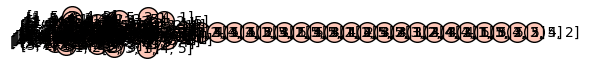

In [121]:
Graph(nx.to_undirected(nxG)).plot()

In [142]:
is_cartesian_product(Graph(nx.to_undirected(nxG)))

False

In [27]:
resg = graph_red_search(nxG)

In [28]:
for x,y in resg.edges():
    print(x)
    resg[x][y][diffweight] = resg[x][y][diffweight].subs(V1=V0,V2=V0,V3=V0,V4=V0,U1=U0,U2=U0,U3=U0,U4=U0)
    if resg[x][y][diffweight] == 0:
        resg.remove_edge[x][y]

[5, 1, 3, 2, 4]


NameError: name 'diffweight' is not defined

In [111]:
myring = LaurentPolynomialRing(QQ, ('x','y'))

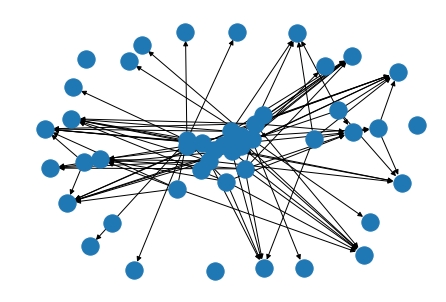

In [44]:
nx.draw(nxG)
for x,y in nxG.edges():
#     print(x)
    nxG[x][y]['diffweight'] = str(nxG[x][y]['diffweight'])
nx.write_gml(nxG, 'pleasegod.gml')

In [59]:
nxcomp = nx.DiGraph(dictg)

In [73]:
redg = graph_red_search(nxcomp)
for edge in redg.edges():
    redg

TypeError: 'tuple' object does not support item assignment

In [60]:
redg = graph_red_search(nxg)

In [61]:
redg.edges()

OutEdgeView([('[1, 2, 3]', '[2, 1, 3]'), ('[1, 2, 3]', '[1, 3, 2]'), ('[2, 1, 3]', '[1, 2, 3]'), ('[2, 1, 3]', '[2, 3, 1]'), ('[1, 3, 2]', '[1, 2, 3]'), ('[1, 3, 2]', '[2, 3, 1]'), ('[2, 3, 1]', '[2, 1, 3]'), ('[2, 3, 1]', '[1, 3, 2]')])

In [62]:
redg.nodes()

NodeView(('[1, 2, 3]', '[2, 1, 3]', '[1, 3, 2]', '[2, 3, 1]'))

In [64]:
redg.get_edge_data('[1, 2, 3]', '[2, 1, 3]')

{'weight': U0}

In [55]:
g

In [61]:
testmat = matrix([[1,0,U1],[V0,1,V2],[U0,U1,V2]])
testmat

[ 1  0 U1]
[V0  1 V2]
[U0 U1 V2]

In [107]:
myf.add_multiple_of_row(1,2,U1)

In [33]:
g.get_edge_data(list(g.edges())[0][0],list(g.edges())[0][1])['weight']

[1, 0, 0, 0, 0, 0]

In [ ]:
iterate through dictionary keys(dict)
    tracker = -1
    for target in keydic
        if target weight == 1
            graph reduction alg
            tracker = 1
    if tracker == 1
        return rerun
    else
        return
        
graph reduction(dict, key, target)
    for x in predecessors(target)
        if x == key: continue
        for y in successors(key)
            if y == target: continue
            x_weight = thegraph[x][targ]['weight']
            y_weight = thegraph[key][y]['weight']
            W = x_weight x y_weight
            add edge to graph from x to y weight = W
    delete key
    delete target
    return graph

In [ ]:
#OLD CODE

# def reduce_around(M, position): 
# #M isa matrix and position is a pair [a,b] where a 1 is located
# #function does Gauss-Jordan-ish elimination on that column and in a symmetric way to the entry's row
#     a,b = position
#     #First step is to use the row to cancel the other entries, then we'll do a symmetric cancellation on
#     #the columns as well
#     column = M[:][b]
#     for index, entry in enumerate(column):
#         if ((index != 0) and (index != a) and (entry != 0)):
#             M.add_multiple_of_row(index, entry, a)
#     for index, entry in enumerate(column):
#         if ((index != 0) and (index != a) and (entry != 0)):
#             M.add_multiple_of_col(index, entry, b)
#     #Now we'll repeat the process but with the row entries
#     row = M[a][:]
#     for index, entry in enumerate(row):
#         if ((index != 0) and (index != b) and (entry != 0)):
#             M.add_multiple_of_col(index, entry, b)
#     for index, entry in enumerate(column):
#         if ((index != 0) and (index != b) and (entry != 0)):
#             M.add_multiple_of_row(index, entry, a)
#     return

# def hom_reduction(adj_mat):
#     M = adj_mat
#     row_position = 0
#     for row in M:
#         check, column_position = row_count(row)
#         if row_count(check[0]) > 1:
#             reduce_around(M, row_position, column_position)
#         row_position = position + 1



# def cinf_coeff(size):
#     n = size
#     varis = name_some_vars(['U','V'],n)
#     F = LaurentPolynomialRing(GF(2), varis)
#     F.inject_variables()
# #     preF = LaurentPolynomialRing(GF(2), 'U', n) #F[Ui+-] which we'll then pair up with the Vi
# #     preF.inject_variables()                     #Telling Sage we have Ui's as variables
# #     Vars = preF.gens()                          #storing the variables in a list - not currently implemented anywhere
# #     for vari in preF.gens():
# #         preF.<vari> = preF
# #     F = LaurentPolynomialRing(preF, 'V', n)     #Takes our preF (F[Ui+-]) and adjoins Vi
# #     F.inject_variables()                        #F only thinks it has Vi as variables, we tell Sage about it
# #     Vars = Vars + F.gens()
# #     for vari in F.gens():
# #        F.<vari> = F
# #     for vari in Vars: 
# #         F.<vari> = F    
#     return F,list(F.gens())

# def find_one(targetlist): #Searches a list for first 1 - will be used for reduction
# #     print("searching for 1 in" + str(targetlist))
#     if 1 in list(targetlist):
        
# #         print("found 1 in the list at" + str(list(targetlist).index(1)))
#         return list(targetlist).index(1)

#     return -1

# def find_col_with_one(matrix, startc=0):
    
#     endc = len(matrix[0])
#     print(str(endc))
#     for n in range(startc, endc):
        
#         search_result = find_one(matrix[:][n])
#         if search_result != -1: return (search_result, n)
        
#     return (-1, -1)


# def reduction_remap(matrix, row, col):
#     n = len(matrix[0])
#     range1 = range_skip_entry(n, row)
# #     print("searching through " + str(range1))
#     for count, target_row in enumerate(range1):
        
#         entry = matrix[target_row][col]
#         if entry != 0: my_row_add(matrix, row, target_row, entry)
            
#     return matrix

# def row_col_del(matrix, loc):
#     newrange = list(range(len(matrix[0])))
#     del newrange[loc]
#     return matrix[newrange,newrange]

# def construct_sageG_cinf(g, size = -1): #Construct CFKinf complex from graph data - essentially just changing weights to polynomials
#                                   #Only works for grid diagrams *not* Latin Squares
#     #DEPRECATED None of the current pipelines are using sage graphs
#     if size == -1:
#         size = len(g.get_edge_data(list(g.edges())[0][0],list(g.edges())[0][1])['diffweight'])  #kind of a mess - just turning the edges
#     n = size/2                                                                              #into a list and checking the length of
#                                                                                             #the weight of the first edge
#     F,Vars = cinf_coeff(n)
#     resG = DiGraph()
#     for edge in g.edges:
        
#         start = edge[0]
#         end = edge[1]
#         poly = F(1)
#         i = 0
#         for entry in g[edge[0]][edge[1]]['diffweight']:
            
#             poly = poly*(Vars[i])**entry
#             i = i + 1
            
#         resG.add_edge(start, end, poly)
        
#     return resG

# def convert_gml(fileName): #GridToolsTBD exports to a text file - this grabs it and converts the edges back to lists
#                            #super inneficient - should convert to pickle file system or something
#     g = nx.read_gml(fileName)
#     for edge in g.edges:
#         g[edge[0]][edge[1]]['diffweight'] = ast.literal_eval(g[edge[0]][edge[1]]['weight'])
#         g[edge[0]][edge[1]]['diffweight'] = g[edge[0]][edge[1]]['diffweight'][0]+g[edge[0]][edge[1]]['diffweight'][1] #end result is edge weights as list of
#                                                                                                           #multiplicities [U1,U2...,Un,V1,...,Vn]
#     return g

# def imp_and_construct_complex(filename):
    
#     #Input: Filename string for a file
    
#     print('importing complex...')
#     g = convert_gml(filename)
#     return construct_cinf(g)

# def reduction(matrix):
#     col, row = find_col_with_one(matrix)
# #     print("reducing around entry " +str(row) + "," +str(col))
#     if col == -1:
        
#         print("completed reduction")
#         print(matrix)
#         print (type(matrix))
#         return matrix
    
#     print("reduction in progress")
#     remapped_matrix = reduction_remap(matrix, row, col)
#     if row < col:
        
#         remapped_matrix = row_col_del(remapped_matrix, col)
#         remapped_matrix = row_col_del(remapped_matrix, row)
        
#     else:
        
#         remapped_matrix = row_col_del(remapped_matrix, row)
#         remapped_matrix = row_col_del(remapped_matrix, col)
        
#     return reduction(remapped_matrix)
    
# def my_row_add(matrix, row, targetrow, multiple):
#     n = len(matrix[0])
#     for i in range(n):
#         current_src = matrix[row][i]
#         if current_src != 0:
# #             print("adding copies times " + str(current_src))
# #             print("multiple" + str(multiple))
# #             print("target entry " + str(matrix[targetrow][i]))
#             matrix[targetrow,i] = matrix[targetrow][i] + multiple*current_src
# #         print(matrix)
#     return matrix


# def alex_power_change(poly, field):
    
#     gens = field.gens()
#     size = len(gens)/2
#     grade = 0
#     powers = poly.exponents()
#     if len(powers) > 1:
        
#         raise Exception("Ran into a non-homogoneous degree change - polynomial wasn't a monomial")

#     if len(powers) == 0:
        
#         return 0
        
#     powers = powers[0]
#     for i in range(size):
        
#         grade = grade - powers[i] + powers[i+size]
        
#     return grade
